<a href="https://colab.research.google.com/github/Voland24/ModernComputerVisionPytorch/blob/main/Chapter4_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional NN

This chapter deals with CNNs, firstly by viewing its hyperparams, strides, pooling and filters. Then, we'll look at various data augmentations implemented to improve model performance. We'll then visualize the learned features of the CNN and then apply it all to a real world example.

# Problem with NNs

The problem of the MLP model for image classification and in general, image problems is that one, the model complexity increases with the image resolution, for example, an HD image, 1024*1024 pixels would have a milion inputs for the NN. This leads to huge models and they are almost impossible to train. Also, simple MLPs aren't robust enough to handle geometric and photometric transformations. Meaning, any change in lighting or the position of the object of interest be it translation, rotation, scaling would confuse the model and render it useless.

# CNNs

They consist of convolutions, filters, strides, padding and pooling.

Applyying a convolution matrix to an image, called a kernel, produces a matrix called a filter, which is typically smaller than the original image. These filters are the various thing the model learns from the image. CNNs are trained by training the kernel matricies i.e. treating their values as weights. There are multiple kernels for the same image and all of them learn a different thing from the image.

If the image is RGB meaning it has three channels, the kernel would also have three channels, one for each dimensions. THe result of a single convolution step is always a scalar.

**Stride** defines by how much the kernels slides over the image, it can be 1 or 2 usually. The more it strides over the smaller the resulting filter is.

**Padding** is the process of adding additional 0 to the image around its borders to keep the dimension of the filter the same size as the image itself.

**Pooling** is the process of applying a transformation to the filter that's a result of applying the kernels to the image. It works almost identical to the kernel, but instead of applying a transformation it simply chooses the average of the max value of the elements it oversees.

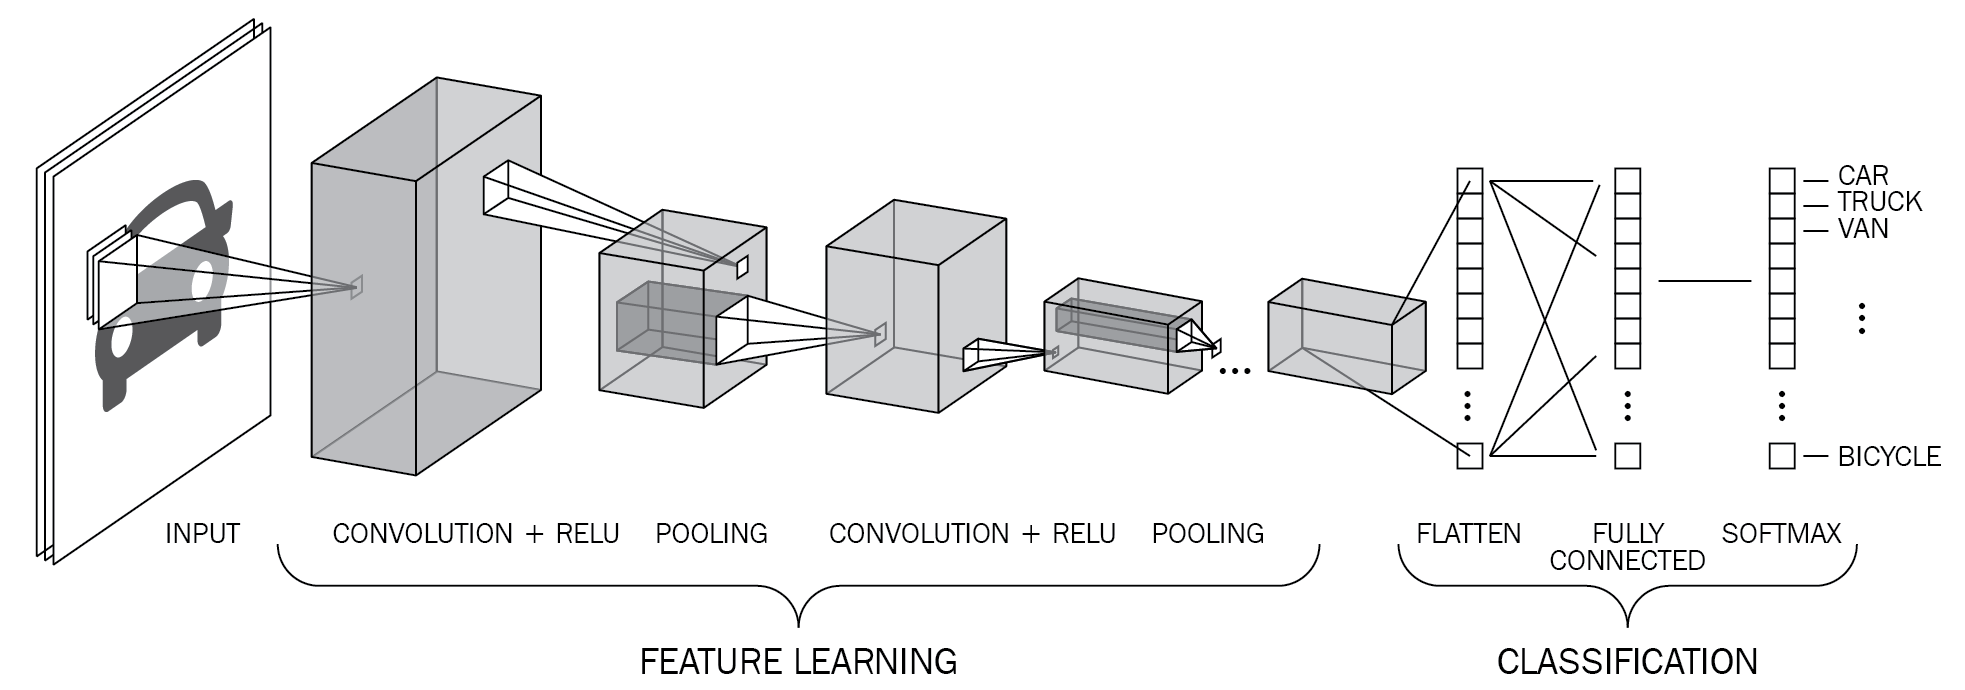

Here we see the overview of the architecture. We keep applying the convolutin + acttivation function to image data, the pooling to the results and repeat the process a couple of times. After that, we flatten the last pooling layer output and we can feed that into a MLP for classification. More importantly, that last pooling flattened vector represents the image in a vector form, it's the image's deep embedding and can be used after that in a way we see fit.
This is called feature learning. The flattened layer represents a much smaller and more compact description of what lies on the image then the raw image data.

**Pooling and convolutin intuition**

This helps us achieve geometric and photometric invariance of the model ot a larger extent then the MLP model. 
After convolution we have a single number to represent a pathc of the original image. Then, after pooling we average out or choose the max value of several those patches and force the model ot adjust it's weights i.e. kernels to accomodate such an approach. This leads to robust models and teaches the models to generalize and fair well in situations where the image is rotated, scaled, translated and such.

# Let's implent the CNN

In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset,DataLoader
from torch.optim import SGD,Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

THe models expects the inputs in a N * C* H * W
format meaning
N - how many images at once, i.e. batch size
C - how many channels per image i.e RGB, grayscale
H - height of the image in pixels
W - width of the image in pixels

Dividing by 8 just keep the values in the -1 to +1 range.

In [2]:
X_train = torch.tensor([[[[1,2,3,4],[2,3,4,5], \
[5,6,7,8],[1,3,4,5]]], \
[[[-1,2,3,-4],[2,-3,4,5], \
[-5,6,-7,8],[-1,-3,-4,-5]]]]).to(device).float()

X_train /= 8
y_train = torch.tensor([0,1]).to(device).float()

THe shape of the input dataset if 2 * 1 * 4 * 4
Meaning we have two datapoints each a 4*4 matrix with 1 channel

CNN architecture

In [3]:
def get_model():
  model = nn.Sequential(
      nn.Conv2d(1,1, kernel_size = 3),
      nn.MaxPool2d(2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(1,1),
      nn.Sigmoid()
  ).to(device)

  loss_fn = nn.BCELoss() #binary cross entropy loss for classiffcation
  optimizer = Adam(model.parameters(), lr = 1e-3)
  return model, loss_fn, optimizer

Here we extract 1 feature map i.e. one filter with a 3*3 kernel for a 4*4 iamge. Then we maxpool the feature map and flatten it. It is then fed through a linear activation and then a sigmoid for a prediction of the class.

In [6]:
!pip install torch_summary
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, X_train);


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 1, 2, 2]             10
├─MaxPool2d: 1-2                         [-1, 1, 1, 1]             --
├─ReLU: 1-3                              [-1, 1, 1, 1]             --
├─Flatten: 1-4                           [-1, 1]                   --
├─Linear: 1-5                            [-1, 1]                   2
├─Sigmoid: 1-6                           [-1, 1]                   --
Total params: 12
Trainable params: 12
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00


Why are there 12 params to learn?
We are convoling a 3*3 kernel over a 1 * 4 * 4 shape, and getting a 1 * 2 *2 output i.e the feature map for the input image.
There are 3*3 = 9 params in the kernel, think of weights and one bias term in the kernel.
The pooling, relu and flatten layers have to params.
The only ones left are the weight and the bias in the Linear term.

**Let's train the model**

In [7]:
def train_batch(x, y, model, optimizer, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction.squeeze(0), y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()


Since we won't modify the data here, we don't have to make a separate Dataset class like before, we can simply use the TensorDataset class here to achieve the same thing.

In [8]:
trn_dl = DataLoader(TensorDataset(X_train, y_train))
for epoch in range(2000):
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x,y, model, optimizer, loss_fn)

We train the model for 2000 epochs and we can perform the forward pass after it's done

In [7]:
model(X_train[:1])

tensor([[0.0053]], grad_fn=<SigmoidBackward0>)

How did we get this value?


In [8]:
list(model.children())

[Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1)),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 ReLU(),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=1, out_features=1, bias=True),
 Sigmoid()]

Get all the learnable params from the CNN

In [10]:
(cnn_weights, cnn_bias), (lin_weights, lin_bias) = [(layer.weight.data, layer.bias.data) for layer in list(model.children()) if hasattr(layer, 'weight')]


The linear weight and bias are both scalars.
The cnn bias term is also a scalar.
The cnn weights are a tensor of 1 * 3 * 3, 
which coresponds to a single kernel with the shape of 3*3.

In [11]:
img_height, img_width = X_train.shape[2:]
kernel_height, kernel_width = cnn_weights.shape[2:]
sumprod = torch.zeros((img_height - kernel_height + 1, img_width - kernel_width + 1))


sumprod is used for storing the result of the convolution and has the shape given in the code above.
Let's convolve the kernel over the image data

In [12]:
for i in range(img_height - kernel_height + 1):
  for j in range(img_width - kernel_width + 1):
    img_subset = X_train[0,0, i:(i+3), j:(j+3)]
    model_filter = cnn_weights.reshape(3,3)
    val = torch.sum(img_subset * model_filter) + cnn_bias
    sumprod[i,j] = val

print(sumprod)

tensor([[2.1574, 2.8922],
        [2.8595, 3.6192]])


In [13]:
#ReLU activation
sumprod.clamp_min_(0)

tensor([[2.1574, 2.8922],
        [2.8595, 3.6192]])

Maxpooling

In [14]:
pooling_output = torch.max(sumprod)

Apply the linear layer

In [15]:
lin_layer_output = pooling_output * lin_weights + lin_bias

Sigmoid activation

In [17]:
print(torch.sigmoid(lin_layer_output))

tensor([[0.0053]])


# Classifying images with DCNNs

We will classify the same FashionMNIST dataset.
The preprocesing is pretty much the same except we won't flatten the  images as before to feed them in the network, we will transform each image to be a 1 * 28 * 28 tensor, because that's the format out CNN expect. 

In [9]:
data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download = True, train = True)
tr_images = fmnist.data
tr_targets = fmnist.targets

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [10]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float() / 255 #normalize
    x = x.view(-1,1,28,28) #turn into tensor of 1 * 28 * 28
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)


In [11]:
def get_model():
  model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size = 3), #64 kernels of 3*3 size
        nn.MaxPool2d(2), # 2*2 pooling matrix
        nn.ReLU(),
        nn.Conv2d(64,128,kernel_size=3), # 64 feature maps on input through 128 kernels of 3*3
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256), #3200 element input vector to 256 outputs
        nn.ReLU(),
        nn.Linear(256, 10) #the hidden layer output of 256 elements to 10 classes
  ).to(device)

  loss_fn = nn.CrossEntropyLoss() #FOR MULTICLASS
  optimizer = Adam(model.parameters(), lr = 1e-3)
  return model, loss_fn, optimizer





In [12]:
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,1,28,28))


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Where are the params from?

**Layer 1**: 64 kernels with a size of 3 so we have 64 * 3 * 3 weights and 64 * 1 biases so in total 640 params
**Layer 4** : 128 kernels with a size of 3*3 per each of the 64 feature maps so we have 64 * 128 * 3 * 3 weights and 128 * 1 biases so in total 73856 params
**Layer 8** : We have 3200 inputs neurons connected to 256 hidden layer neurons in a fully connected network so we have 3200 * 256 weights + 256 biases so that is 819456 params
**Layer 10** : 266 hidden layers neurons connected to 10 output layer neurons is 256 * 10 weights + 10 biases is 2570 params



In [13]:
val_fmnist = datasets.FashionMNIST(data_folder, download = True, train = False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size = 32, shuffle = True )
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size = len(val_images), shuffle = True)
  return trn_dl, val_dl

In [17]:
@torch.no_grad()
def accuracy(x, y, model):
  model.eval()
  prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x,y,model):
  model.eval()
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [15]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

summary(model, torch.zeros(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [18]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(f"Epoch number {epoch + 1}")
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    batch_loss = train_batch(x,y,model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x,y = batch
    is_correct = accuracy(x,y,model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x,y = batch
    val_is_correct = accuracy(x,y,model)
    validation_loss = val_loss(x,y,model)
  val_epoch_accuracy = np.mean(val_is_correct)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)


Epoch number 1
Epoch number 2
Epoch number 3
Epoch number 4
Epoch number 5


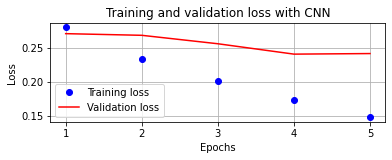

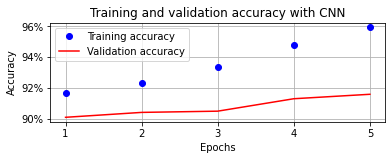

In [19]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

Let's translate the image +-5 pixels and try to predict the class

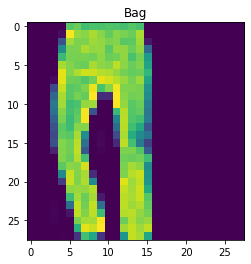

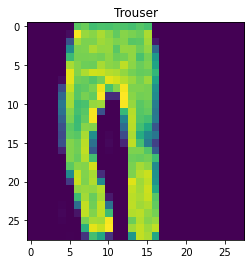

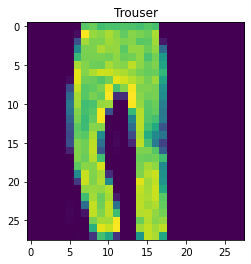

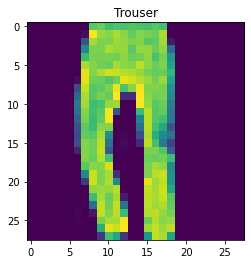

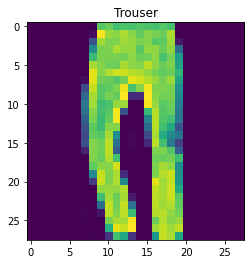

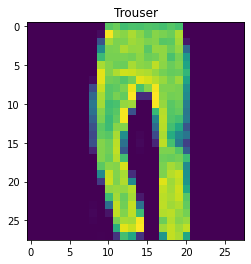

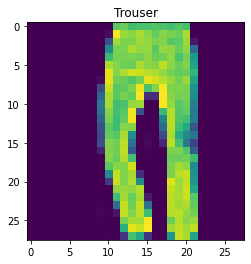

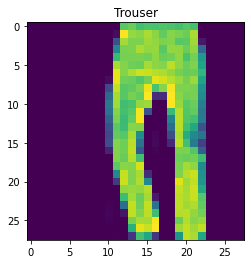

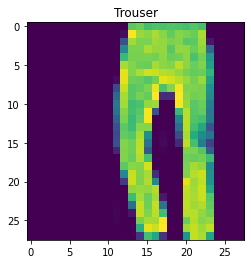

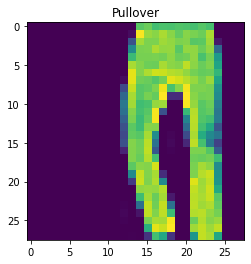

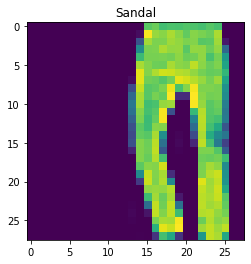

In [23]:
preds = []
ix = 24300
for px in range(-5,6):
  img = tr_images[ix] / 255.
  img = img.view(28,28)
  img2 = np.roll(img, px, axis = 1)
  img3 = torch.Tensor(img2).view(-1,1,28,28).to(device)
  np_output = model(img3).cpu().detach().numpy()
  pred = np.exp(np_output) / np.sum(np.exp(np_output))
  preds.append(pred)
  plt.imshow(img2)
  plt.title(fmnist.classes[pred[0].argmax()])
  plt.show()


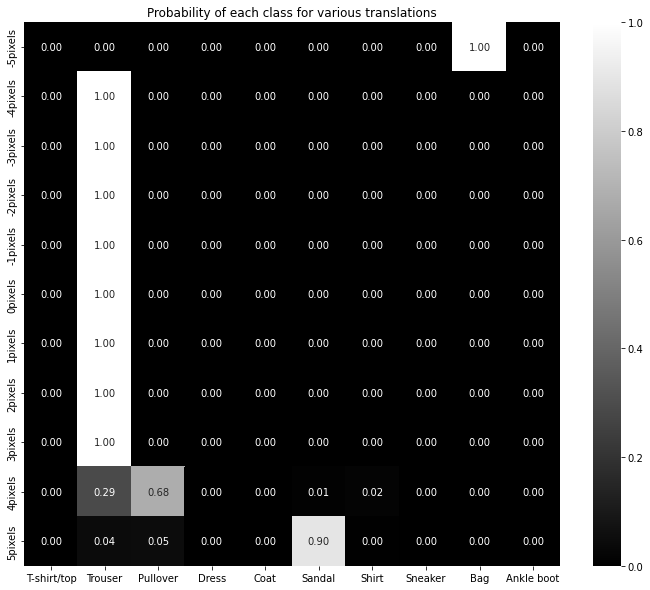

In [24]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize = (12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), annot = True, ax = ax, fmt = '.2f', xticklabels = fmnist.classes, yticklabels = [str(i) + str('pixels') for i in range(-5,6)],cmap = 'gray')
